# **PyTorch & (by hand) gradient descent**

**Disclaimer**: large parts of the lab are taken from [Deep Learning with PyTorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) by [Soumith Chintala](http://soumith.ch/) and lectures material of [Sebastian Goldt](https://datascience.sissa.it/research-unit/12/theory-of-neural-networks).

# **Neural Network: an intuitive definition**

Neural networks (NNs), combination of functions, are nested functions over some input data. The functions are defined by weights and biases (in tensor form), the _trainable parameters_.

The training of a NN is made by two phases:

**Forward Propagation**: the NN makes _a prediction_ and does its best to guess the output by means of the nested functions, I give an input and an output.

**Backward Propagation**: the NN optimizes the parameters trying to lower the _loss_. To do that, it starts from the output and goes _backwards_, computing the derivatives (the _gradients_) of the loss with
respect to the trainable parameters and optimizing them by means of gradient descent. If you want to deepen your knowledge, check [this video](https://www.youtube.com/watch?v=tIeHLnjs5U8) out --> the NN optimize the parameters, updateted it (only an opt phase to perform fastely the computation).

# **Gradient Descent by hand**

**GOAL**: given a number, the NN has to say if it is even or odd.

We want to understand if a number is even or odd. To do so, we take a datset of numbers and we apply gradient descent method to a set of data.

The gradient descent is the way my Neural Network _optimizes_ the parameters. 

Imagine to have $m$ data and we want to optimize the parameters of the net minimizing the following _mean square error_ loss, I'm try to minimize the discrepancy from the output of my network $(y^{nn})$ and the data that I have $(y)$:

$$
L = \frac{1}{m}\sum_i^m (y^{nn}_i - y_i)^2
$$

where $\displaystyle y^{nn}_i = w \cdot x_i + b$, we now use linear prediction from the NN. The gradient descent algorithm is based on the idea that the _faster_ way to reach a minimum is to follow the negative gradient of the quantity we want to minimize.

We need to compute the derivates wrt the weights (with the chain rule rebembering $y^{nn}_i = w \cdot x_i + b$) and the bias $b$ (applaying again the chain rule):
$$
\frac{\partial L}{\partial w} \quad \text{ and } \quad \frac{\partial L}{\partial b}. 
$$

In the specific case of the mean square error we have:
$$
\frac{\partial L}{\partial w} = \frac{2}{m}\sum_i^m x_i( w \cdot x_i + b - y_i),
$$
while 
$$
\frac{\partial L}{\partial b} = \frac{2}{m}\sum_i^m ( w \cdot x_i + b - y_i).
$$

The new parameter are, given a _learning rate_ $\lambda$, that explain "how much I'm going down" / "how fast I'm moving" / "how far I'm looking":

$$
w = w - \lambda \frac{\partial L}{\partial w} 
\quad \text{ and } \quad 
b = b - \lambda \frac{\partial L}{\partial b}.
$$

NB It's very important to tuning $\lambda$: start with a large number, after reduce it again and again.

In [17]:
num_samples = {"train": 2000, "test": 5000} # Dictionary 2000 data for training & 5000 to test, we select this data to know if we generalize well

In [18]:
import torch
from torchvision import datasets, transforms
import numpy as np

In [19]:
modes = ["train", "test"]

#### input = hand-written digits 28x28, output = the number

datasets = {"train": datasets.MNIST("~/datasets/mnist", 
                                   train=True,
                                   download=True),
           "test": datasets.MNIST("~/datasets/mnist", 
                              train=False,
                              download=True)}

**Dataset**: MNIST images. The MNIST dataset contains 28x28 (input) grayscale images of handwritten digits from 0 to 9. The training set has 60,000 samples, the test set has 10,000 samples. The output is an interger label from 0 to 9 (output). --> that are the pixel that you have inside the image

In [20]:
xs = dict()
ys = dict()

for mode in modes:
    xs[mode] = datasets[mode].data[:num_samples[mode]].float() # Input of train and after test
    ys[mode] = datasets[mode].targets[:num_samples[mode]].float() # Label of train and after test

    # Normalize the inputs --> to have a faster training (loosing informations)
    mean, std = (torch.mean(xs[mode]), torch.std(xs[mode]))
    xs[mode] = (xs[mode] - mean) / std 
    
    ys[mode] = 2 * torch.fmod(ys[mode], 2) - 1 # We want to say if the number is even or odd --> I devide my number/label in this cathegory
                                            # even or odd in the usual way (the rest of 2) --> This is important to the training phase

**Question time!!!** What does the above code? Why is it important?

**Answer:** it normilizes the data (useful in many application) and changes the output from a number from 0 to 9 to the "odd class" (1) and "even class" (-1).


**Inside the data**

In [21]:
import matplotlib.pyplot as plt

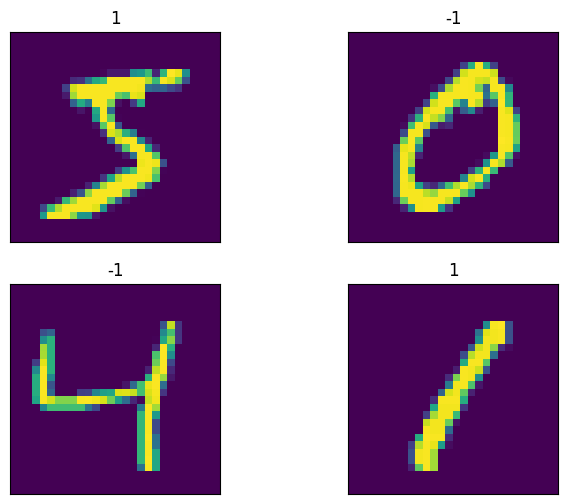

In [22]:
# Plotting input in the train considering 0 := even
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))

plt_idx = 0
for (n_row, n_col), axes in np.ndenumerate(ax):
    axes.imshow(xs["train"][plt_idx])
    axes.set_title("%d" % ys["train"][plt_idx])
    
    axes.set_xticks([])
    axes.set_yticks([])
    
    plt_idx += 1
plt.show()

# **Your turn :)**

Let us have fun! What about implementing the gradient descent algorithm?

In [23]:
import math

In [24]:
xs["train"].shape # 2000 := number of trianing data, 28 x 28 := dimension of the image

torch.Size([2000, 28, 28])

In [25]:
print(ys["train"].shape)
print(ys["train"][0]) # 1 or -1 := odd or even

torch.Size([2000])
tensor(1.)


In [26]:
# As numpy reshape 2000 data, 28 x 28 --> we want to reshape so that that I obtain a single vector and no more a matrix
xs["train"] = torch.reshape(xs["train"], (num_samples["train"], xs["train"].shape[1]*xs["train"].shape[1]))

In [27]:
print(xs["train"].shape[0]) # 2000
print(xs["train"].shape[1]) # 28 x 28

2000
784


In [28]:
# Same for the test
xs["test"] = torch.reshape(xs["test"], (num_samples["test"], xs["test"].shape[1]*xs["test"].shape[1]))

In [29]:
print(xs["test"].shape[0])
print(xs["test"].shape[1])

5000
784


In [30]:
x_train = xs['train']
y_train = ys['train']
x_test = xs['test']
y_test = ys['test']
w = torch.rand(x_train.shape[1], requires_grad=True)
b = torch.rand(1)

First of all, define the loss function!

In [31]:
def  loss(w,b,X,y):
    # The same loss that we defined before
    m = X.shape[0] # Number of data, where X is the input matrix
    
    predictions = w @ X.T + b # The bias is fixed, where @ is the matrix product
    
    my_loss = (1/m)* torch.sum((predictions - y)**2) # Mean square error
    return my_loss

Now define the gradient descent algorithm and save how the loss goes for train and test

In [32]:
#### errors dict of "train" and "test"
# Gradient descent algorithm considering only one layer
def gradient_descent(X,y,w,b,errors=None,learning_rate=0.01,epochs=100): # learning_rate here is fixed, but is better if during the train is modified (reduced)
    m =  X.shape[0]
    
    for it in range(epochs): # epochs --> how long we perform the training
        
        # Forward propagation
        prediction = w @ X.T + b
        w_d =  (2/m)*(prediction - y) @ X # derivative of the loss with respect to w --> Be carefull to the transposition operator
        w = w - learning_rate*w_d # update the weight 
        b_d = (2/m)*torch.sum((prediction - y)) # derivative of the loss with respect to b --> Does not depend on the input, no need of @X
        b = b - learning_rate*b_d # update the bias
        
        if errors:
            for mode in modes:
                errors[mode] += [loss(w,b,xs[mode],ys[mode]).item()] # To compute the loss at each iteration
              
    return w, b, errors

In [33]:
#### initialize the data ####

### If you want you can fix the seed...

w = torch.rand(x_train.shape[1], requires_grad=True)
b = torch.rand(1, requires_grad=True)
err = {"train": [], "test": []} # Passing dictionary for train and test --> we want to understand the value of the loss on the trianing part and on the test part so that to undestand if we genelarized well

# Parameters
lr =0.0001
epochs = 150

In [34]:
w, b, errors = gradient_descent(x_train,y_train,w,b,err,lr,epochs)

Let us make a plot!

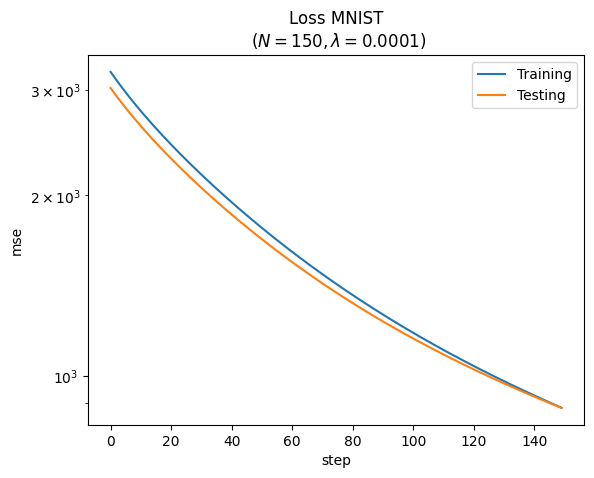

In [35]:
# Plot part
fig, ax = plt.subplots()
ax.semilogy(errors["train"], label="Training")
ax.semilogy(errors["test"], label="Testing")
ax.legend()
ax.set_title("Loss MNIST\n ($N=%d, \lambda=%g$)" % (epochs, lr))
ax.set_xlabel("step")
ax.set_ylabel("mse")
plt.show()

# **An introduction to ``torch.autograd``**

``torch.autograd`` is the way PyTorch computes derivatives. It is the _automatic differentiation_ tool of the
neural network.

**How does it work?**: let us create to tensors ``a`` and ``b`` with
``requires_grad=True``. The latter option tells ``autograd`` to track every operation on the tensors (useful on back propagation, where you do not want to forget any information). Moreover, let us define the tensot ``T`` as

$$ T = a^3 - 2b^2.$$

Pytorch has a module that compute the differentiation automatically. Let's see an example.

In [38]:
import torch

a = torch.tensor([2., 3.], requires_grad=True) # Vector = [2., 3.], requires_grad need for backward --> so that .backward() compute the differentiation wrt this variable
b = torch.tensor([6., 4.], requires_grad=True) # Vector = [6., 4.]
T = a**3 - 2*b**2

In [39]:
print(f"T: {T}")

T: tensor([-64.,  -5.], grad_fn=<SubBackward0>)


In this silly example, the tensors ``a`` and ``b`` are the trainable parameters of an NN, while ``T`` is the _loss_ we want to minimize. In a backward training, we want to compute

$$\frac{\partial T}{\partial a} = 3a^2 \text{ and } \frac{\partial T}{\partial b} = -4b.$$

In the implementation we _need to explicit_ our goal: i.e. compute derivative of ``T``. To do so, we call ``.backward()`` on ``T``: in this way autograd computes the gradients with respect to the parameters and stores them in the ``.grad`` attribute of the tensor, in our case, ``a.grad`` and ``b.grad``.

**Be careful**: we have to pass a ``gradient`` argument in ``T.backward()`` when dealing with vectors. The derivative of ``T`` with respect to ``T`` ia a ``T``-shaped tensor and verifies
$$\frac{dT}{dT} = 1$$

The function ``.backward`` applies without arguments to scalar functions (mean square errors, for example). To do so, we can aggragate all the information of ``T`` summing its elements and, only then, calling the ``.backward`` function: ``T.sum().backward()``.

In [40]:
external_grad = torch.tensor([1., 1.])
T.backward(gradient=external_grad) # The final gradient has to be external_grad, and you tell that you're working with tensors differentiation
# T.sum().backward() --> Different way to achieve quite the same results

In [41]:
# check if collected gradients are correct --> This is simply a check to understand if it's all good
print(3*a**2 == a.grad) 
print(-4*b == b.grad)

tensor([True, True])
tensor([True, True])


# **Your turn :)**

Can you implement gradient descend with ``.autograd``? 

**NB** ``.autograd`` works iff the loss is a scalar.

In [42]:
def  loss(w,b,X,y):
    # Forward model
    predictions = w @ X.T + b
    
    # Defining the loss (in a more directly way)
    my_loss = torch.mean((predictions - y)**2)
    
    return my_loss

In [43]:
def auto_gradient_descent(X,y,w,b,errors=None,learning_rate=0.01,epochs=100):
    
    for it in range(epochs):
        
        my_loss = loss(w,b,X,y) # Compute the loss
        my_loss.backward() # Compute derivatives wrt weight and bias thask to "requires_grad=True" --> Not always I have to compute the gradient for all the variable that I have (PAY ATTENTION)
        
        with torch.no_grad(): # do not trace once again --> At each iteration, you cancel the old information on the gradient
            w = w - learning_rate*w.grad # update w
            b = b - learning_rate*b.grad # update b
            # This variable needs to be differentiate
            w.requires_grad_(True)
            b.requires_grad_(True) 

        # To be sure I'm not saving the information
        w.grad = None
        b.grad = None
    
        with torch.no_grad():
            if errors:
                for mode in modes:
                    errors[mode] += [loss(w,b,xs[mode],ys[mode]).item()] # Saving the loss

    return w, b, errors

In [44]:
#### initialize the data ####
w = torch.rand(x_train.shape[1], requires_grad=True)
b = torch.rand(1, requires_grad=True)
err = {"train": [], "test": []}
lr =0.001
epochs = 500

In [45]:
w, b, errors = auto_gradient_descent(x_train,y_train,w,b,err,lr,epochs)

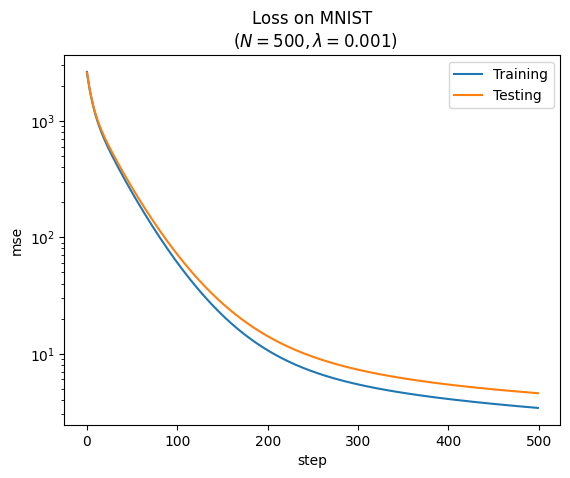

In [46]:
fig, ax = plt.subplots()
ax.plot(errors["train"], label="Training")
ax.plot(errors["test"], label="Testing")
ax.legend()
ax.set_title("Loss on MNIST\n ($N=%d, \lambda=%g$)" % (epochs, lr))
ax.set_xlabel("step")
ax.set_ylabel("mse")
ax.set_yscale("log")
plt.show()